In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython 
from scipy.io.wavfile import write, read

In [2]:
def PreProcessData(xn, frameSize, stepSize):
    xn = np.append(np.zeros(128), xn)
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    iteration = (len(temp) // stepSize) - (frameSize // stepSize) + 1
    
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = temp[start:end]
        
    return dataSet, temp, len(temp), iteration

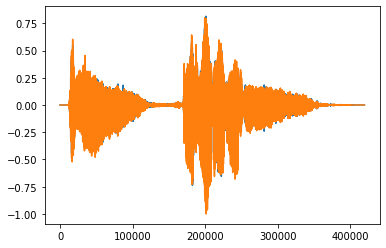

In [3]:
frameSize = 4096
stepSize = 256

file1 = open("impedance_1.dat", mode='r', encoding='utf-8')
ir1 = file1.readlines()
for index, data in enumerate(ir1):
    ir1[index] = float(data.strip().replace(',',''))
ir1 = np.append(ir1, np.zeros(2048))
    
file2 = open("impedance_2.dat", mode='r', encoding='utf-8')
ir2 = file2.readlines()
for index, data in enumerate(ir2):
    ir2[index] = float(data.strip().replace(',',''))
ir2 = np.append(ir2, np.zeros(2048))

rate, file = read("被遺忘的時光intro.wav")
fixed_data0 = file[:, 0]
fixed_data1 = file[:, 1]

float_data0 = fixed_data0.astype(np.float32, order='C') / 32767.0
float_data1 = fixed_data1.astype(np.float32, order='C') / 32767.0

dataSet, data0, length, iteration = PreProcessData(float_data0, frameSize, stepSize)
dataSet, data1, length, iteration = PreProcessData(float_data1, frameSize, stepSize)

plt.plot(data0)
plt.plot(data1)
plt.show()

IPython.display.display(IPython.display.Audio("被遺忘的時光intro.wav", rate = rate))

In [4]:
output = np.zeros(length)
output1 = np.zeros(length)
output2 = np.zeros(length)
Hn1 = np.fft.fft(ir1) / np.max(np.abs(np.fft.fft(ir1)))
Hn2 = np.fft.fft(ir2) / np.max(np.abs(np.fft.fft(ir2)))
blend = 0.5

for i in range(iteration):
    
    Xn = np.fft.fft(dataSet[i])
    Yn1 = np.multiply(Xn, Hn1)
    Yn2 = np.multiply(Xn, Hn2)
    Yn = Yn1 * blend + Yn2 * (1 - blend)
    yn1 = np.fft.ifft(Yn1)
    yn2 = np.fft.ifft(Yn2)
    yn = np.fft.ifft(Yn)
    
    start = i * stepSize
    end = start + stepSize
    
    output[start:end] = yn[-stepSize:].real
    output1[start:end] = yn1[-stepSize:].real
    output2[start:end] = yn2[-stepSize:].real

write("cross_convolution.wav", rate, (output * 32767.0).astype(np.int16))
write("cross_convolution_A.wav", rate, (output1 * 32767.0).astype(np.int16))
write("cross_convolution_B.wav", rate, (output2 * 32767.0).astype(np.int16))

IPython.display.display(IPython.display.Audio("cross_convolution.wav", rate=rate))
IPython.display.display(IPython.display.Audio("cross_convolution_A.wav", rate=rate))
IPython.display.display(IPython.display.Audio("cross_convolution_B.wav", rate=rate))